<a href="https://colab.research.google.com/github/ZaimaSartajTaheri/ResearchCodes/blob/main/Z_CovidDetection_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


In [33]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    # rotation_range=20,
     #width_shift_range=0.1,
    # shear_range=0.1,
     zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [34]:
train = image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Train', 
                                            batch_size=32, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

validation =image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Val', 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='categorical',
                                                target_size=(224, 224))

test =image_generator.flow_from_directory('/content/drive/MyDrive/CovidDataset/CovidDataset/Test', 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

Found 8376 images belonging to 3 classes.
Found 2792 images belonging to 3 classes.
Found 2790 images belonging to 3 classes.


In [35]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
# model.add(Dense(64,activation='relu'))

model.add(Dense(3,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 54, 54, 64)       

In [ ]:
r = model.fit(
    train, 
    epochs=17,
    validation_data=validation,
    validation_steps=100,
)

Epoch 1/17
262/262 [==============================] - 170s 646ms/step - loss: 0.7038 - accuracy: 0.6946 - val_loss: 0.5581 - val_accuracy: 0.7600
Epoch 2/17
102/262 [==========>...................] - ETA: 1:41 - loss: 0.4146 - accuracy: 0.8226

Text(0.5, 1.0, 'Accuracy Evolution')

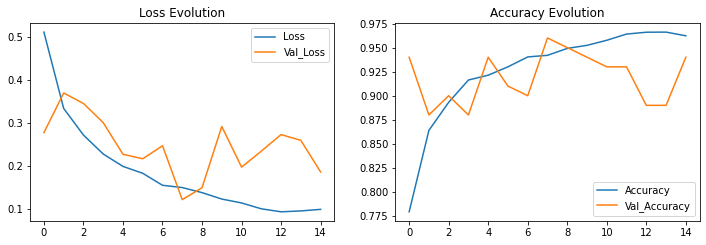

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [16]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

2790/2790 [==============================] - 1628s 584ms/step - loss: 0.2193 - accuracy: 0.9233
Test Accuracy: 92.33%
262/262 [==============================] - 152s 581ms/step - loss: 0.0613 - accuracy: 0.9786
Train Accuracy: 97.86%


In [19]:
from keras.utils.np_utils import to_categorical 
num_classes=len(test.class_indices)

test_labels = test.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes) 
test_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

# rounded_labels=np.argmax(test, axis=1)

pred = model.predict(test)
# pred = np.argmax(predictions, axis=1)

y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(test_labels, axis=1)


cnf_matrix=confusion_matrix(y_test, y_pred)
pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.896694,0.881198,0.992974,0.920789,0.923622,0.923622
recall,0.933333,0.917204,0.911828,0.920789,0.920789,0.920789
f1-score,0.914647,0.898841,0.950673,0.920789,0.921387,0.921387
support,930.000000,930.000000,930.000000,0.920789,2790.000000,2790.000000


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[868  59   3]
 [ 74 853   3]
 [ 26  56 848]]


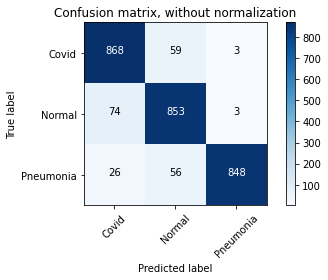

In [30]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Covid', 'Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')